In [1]:
import pandas as pd
import sqlalchemy as sa
from sqlalchemy.dialects.postgresql import JSON, JSONB
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import json
import csv
import datetime
from dateutil.parser import parser
import os
from pprint import pprint
from pathlib import Path
import glob
#from odo import odo
import importlib
import itertools
import sklearn.cluster
import pandas as pd
import numpy as np
import math
import operator
import sklearn
import matplotlib.pyplot as plt

#importlib.invalidate_caches()
%load_ext autoreload
%autoreload 2

In [9]:
tracks = pd.read_pickle("../Pickle_Files/tracks.pkl")
track_elems = pd.read_pickle("../Pickle_Files/track_elems.pkl")
playlists = pd.read_pickle("../Pickle_Files/playlists.pkl")

In [10]:
playlists.head(10)

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid
0,false,None,12395868,1508457600,country songs,41,33,29,1,58,315000
1,false,None,36317989,1505174400,Weekend,113,88,16,3,156,315001
2,false,None,31494581,1491436800,get turnt,120,92,25,3,140,315002
3,false,None,31114725,1506297600,Praise and Worship,15,8,9,1,215,315003
4,false,None,6724683,1504051200,arizona,31,30,25,1,31,315004
5,false,None,49656158,1449878400,Coldplay,44,8,7,1,188,315005
6,false,None,10441658,1392508800,Yeah,28,6,4,1,47,315006
7,false,None,10911817,1386374400,ya bish,7,4,3,1,40,315007
8,false,None,40039208,1485993600,Rock,102,64,35,1,166,315008
9,false,None,5456315,1400284800,Mama,16,14,7,1,17,315009


In [30]:
d = {'pid':'first','num_followers': 'sum','num_tracks':'first'}
grouped_playlists = playlists.groupby('pid', as_index=True).aggregate(d).reindex(columns=['num_followers','num_tracks'])

In [31]:
grouped_playlists.head()

,num_followers,num_tracks
pid,,
0,1,52
1,1,39
2,1,64
3,1,126
4,2,17


In [32]:
all_songs = pd.merge(grouped_playlists,track_elems,on='pid')

In [38]:
group = {'track_uri':'first','num_followers':'sum'}
grouped_songs = all_songs.groupby('track_uri', as_index=True).aggregate(d).reindex(columns=['num_followers'])

In [40]:
grouped_songs = pd.merge(grouped_songs,track_elems[['track_uri','COUNT(*)']],on='track_uri')

In [43]:
grouped_songs = grouped_songs.drop_duplicates()

In [47]:
grouped_songs = grouped_songs.reset_index().drop('index',axis=1)

In [146]:
grouped_songs['popularity'] = grouped_songs['num_followers']/grouped_songs['COUNT(*)']

#### We can see the songs with the highest popularity below have very little playlist inclusions ( COUNT(*) )
<br> A weighted formula is needed

In [147]:
grouped_songs.sort_values(by='popularity',ascending=False).head(5)

,track_uri,num_followers,COUNT(*),popularity,Popularity_Rating,Popularity_Rating_Normalized
1772132,spotify:track:669rlJ42fC74kLaNKXJNaF,22102,1,22102.0,0.688685,0.728443
939908,spotify:track:3EAnWUBXPUDDmMJ8GBrqKt,22102,1,22102.0,0.688685,0.728443
2121878,spotify:track:7J57Z9jti07gqBLBrXkAn4,22102,1,22102.0,0.688685,0.728443
988603,spotify:track:3OcnMblYvWBN4UHeET4bJ0,22102,1,22102.0,0.688685,0.728443
647660,spotify:track:2Dqgu96bZ9fRLIo7ACYcXT,23502,2,11751.0,0.686428,0.718001


In [148]:
N = len(grouped_songs)

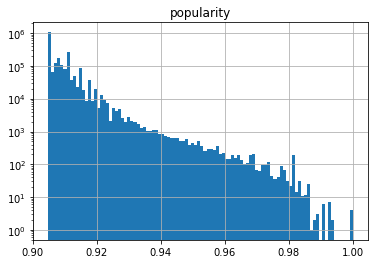

In [149]:
pd.DataFrame(np.power(grouped_songs['popularity'].astype(float)/grouped_songs['popularity'].max(), 0.01)).hist(bins=100)
plt.yscale('log')

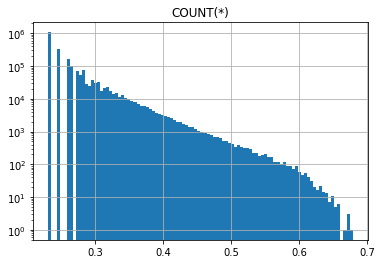

In [150]:
pd.DataFrame(np.power(grouped_songs['COUNT(*)']/N, 0.1)).hist(bins=100)
plt.yscale('log')

#### Weighted Formula

In [231]:
weight = .3
grouped_songs['Popularity_Rating'] = weight * np.power((grouped_songs['popularity']/grouped_songs.popularity.max()
                                                       ), .05)\
+ (1-weight)* np.power((grouped_songs['COUNT(*)']/N), .05)

In [232]:
### Normalise Popularity_Rating
grouped_songs['Popularity_Rating_Normalized']=(grouped_songs['Popularity_Rating']-grouped_songs['Popularity_Rating'].min())/(grouped_songs['Popularity_Rating'].max()-grouped_songs['Popularity_Rating'].min())

In [233]:
graph = pd.DataFrame(grouped_songs['Popularity_Rating_Normalized'])

<Figure size 432x288 with 0 Axes>

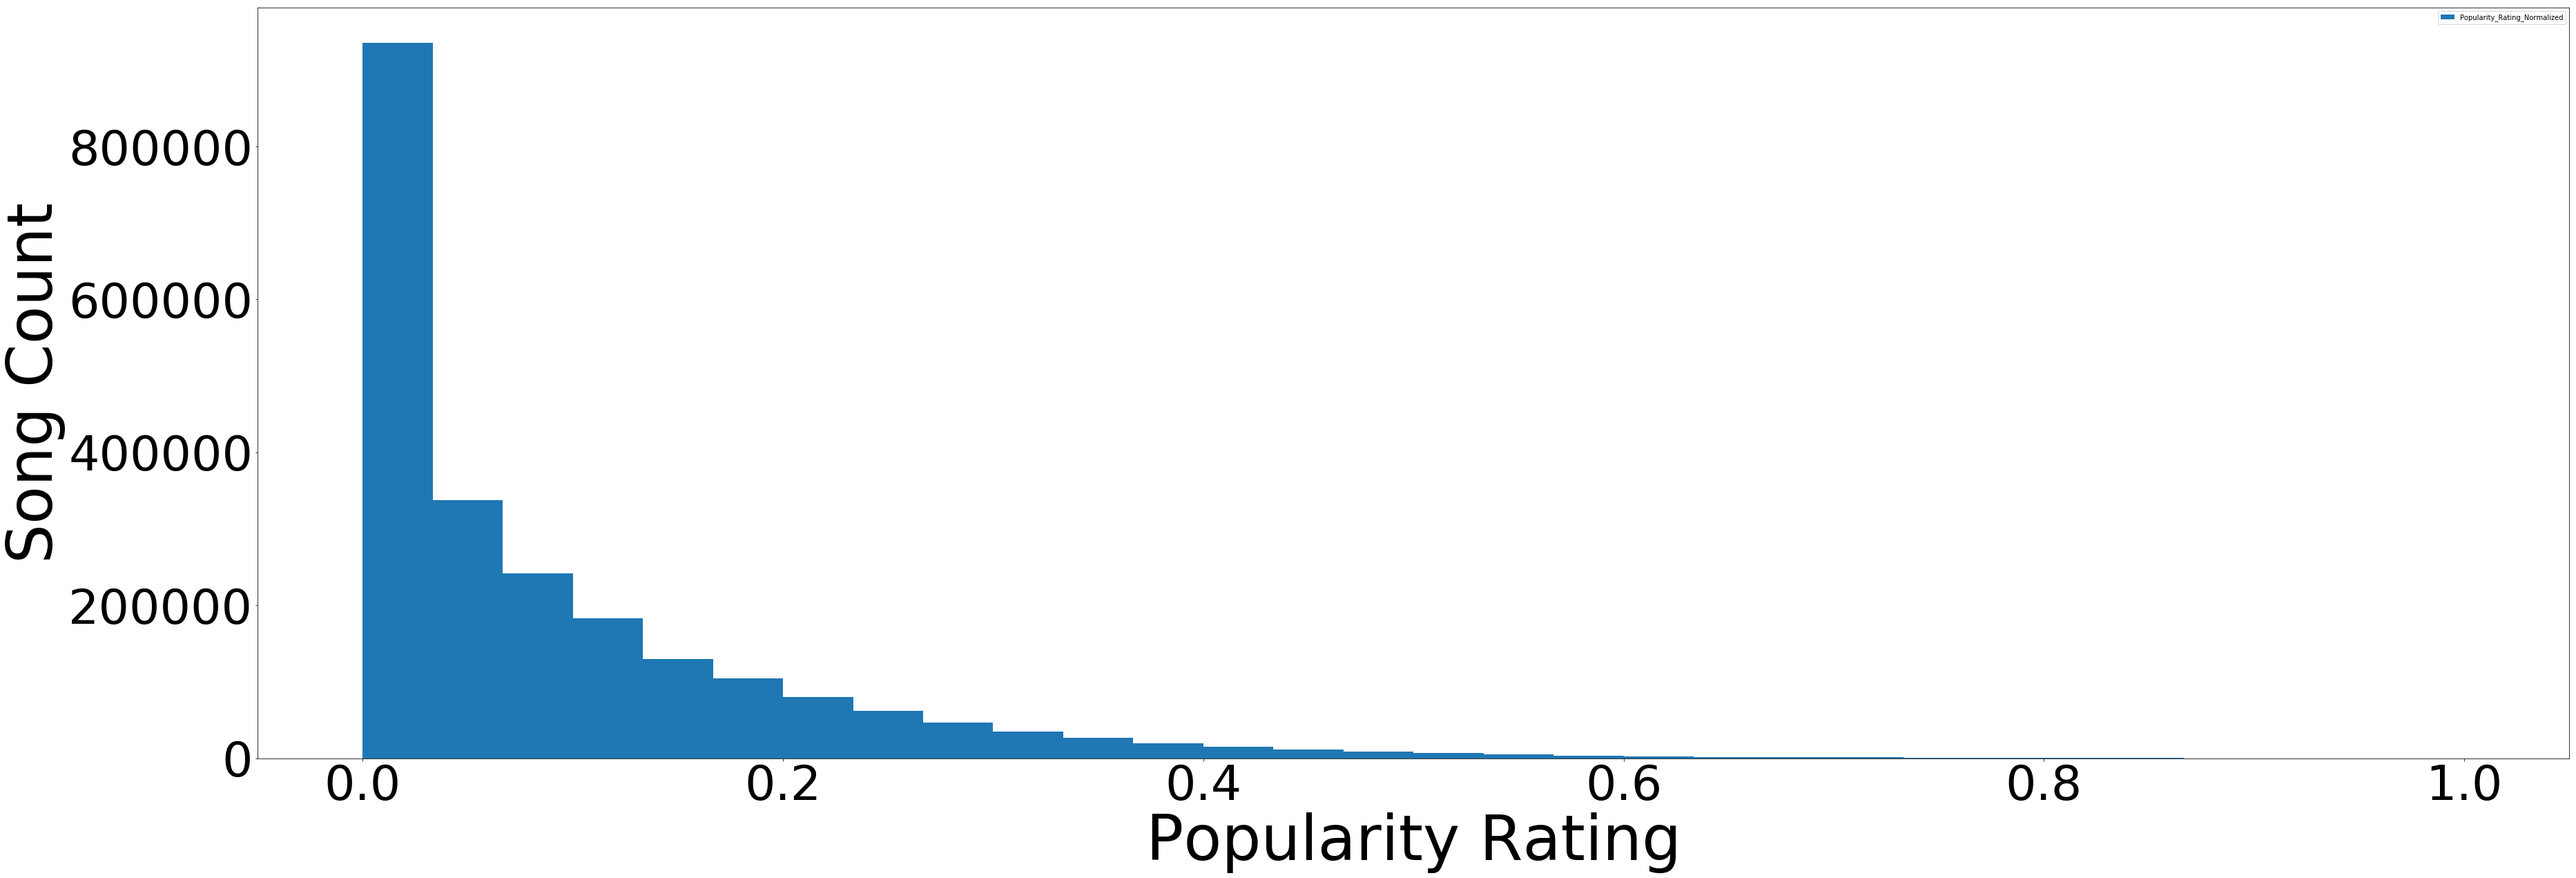

In [275]:
fig = plt.figure()
graph.plot(kind='hist',bins=30,figsize=(60,20),fontsize=70)
fig.suptitle('test title', fontsize=20)
plt.xlabel('Popularity Rating', fontsize=90)
plt.ylabel('Song Count', fontsize=90)
plt.draw()

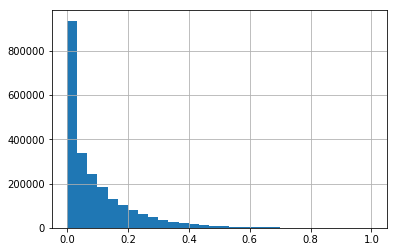

In [240]:
grouped_songs['Popularity_Rating_Normalized'].hist(bins=30)

In [246]:
grouped_songs = grouped_songs.sort_values(by='Popularity_Rating_Normalized',ascending=False)
grouped_songs.head(5)

,track_uri,num_followers,Popularity_Rating_Normalized
2128659,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,110286,1.000000
573135,spotify:track:1xznGGDReH1oQq0xzbwXa3,93456,0.988251
2085721,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,89506,0.982251
2257360,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,83430,0.980005
1041889,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,87291,0.979210


In [247]:
grouped_songs = grouped_songs[['track_uri','num_followers','Popularity_Rating_Normalized']]

In [248]:
grouped_songs.head(5)

,track_uri,num_followers,Popularity_Rating_Normalized
2128659,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,110286,1.000000
573135,spotify:track:1xznGGDReH1oQq0xzbwXa3,93456,0.988251
2085721,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,89506,0.982251
2257360,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,83430,0.980005
1041889,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,87291,0.979210


In [249]:
grouped_songs.to_pickle('../Pickle_Files/Song_Popularity.pkl')

## Playlist Popularity

In [287]:
grouped_playlists = pd.merge( all_songs[['pid','track_uri']],grouped_songs,on='track_uri' )

In [288]:
p = {'Popularity_Rating_Normalized': 'mean','num_followers':'mean'}
grouped_playlists = grouped_playlists.groupby('pid', as_index=False).aggregate(p).reindex(columns=grouped_playlists.columns)

In [289]:
grouped_playlists = grouped_playlists[['pid','Popularity_Rating_Normalized','num_followers']]

In [290]:
grouped_playlists = grouped_playlists.set_index('pid')

In [291]:
grouped_playlists.head(5)

,Popularity_Rating_Normalized,num_followers
pid,,
0,0.778082,19785.000000
1,0.568016,13992.666667
2,0.412681,479.453125
3,0.314665,915.841270
4,0.682966,11521.000000


<Figure size 432x288 with 0 Axes>

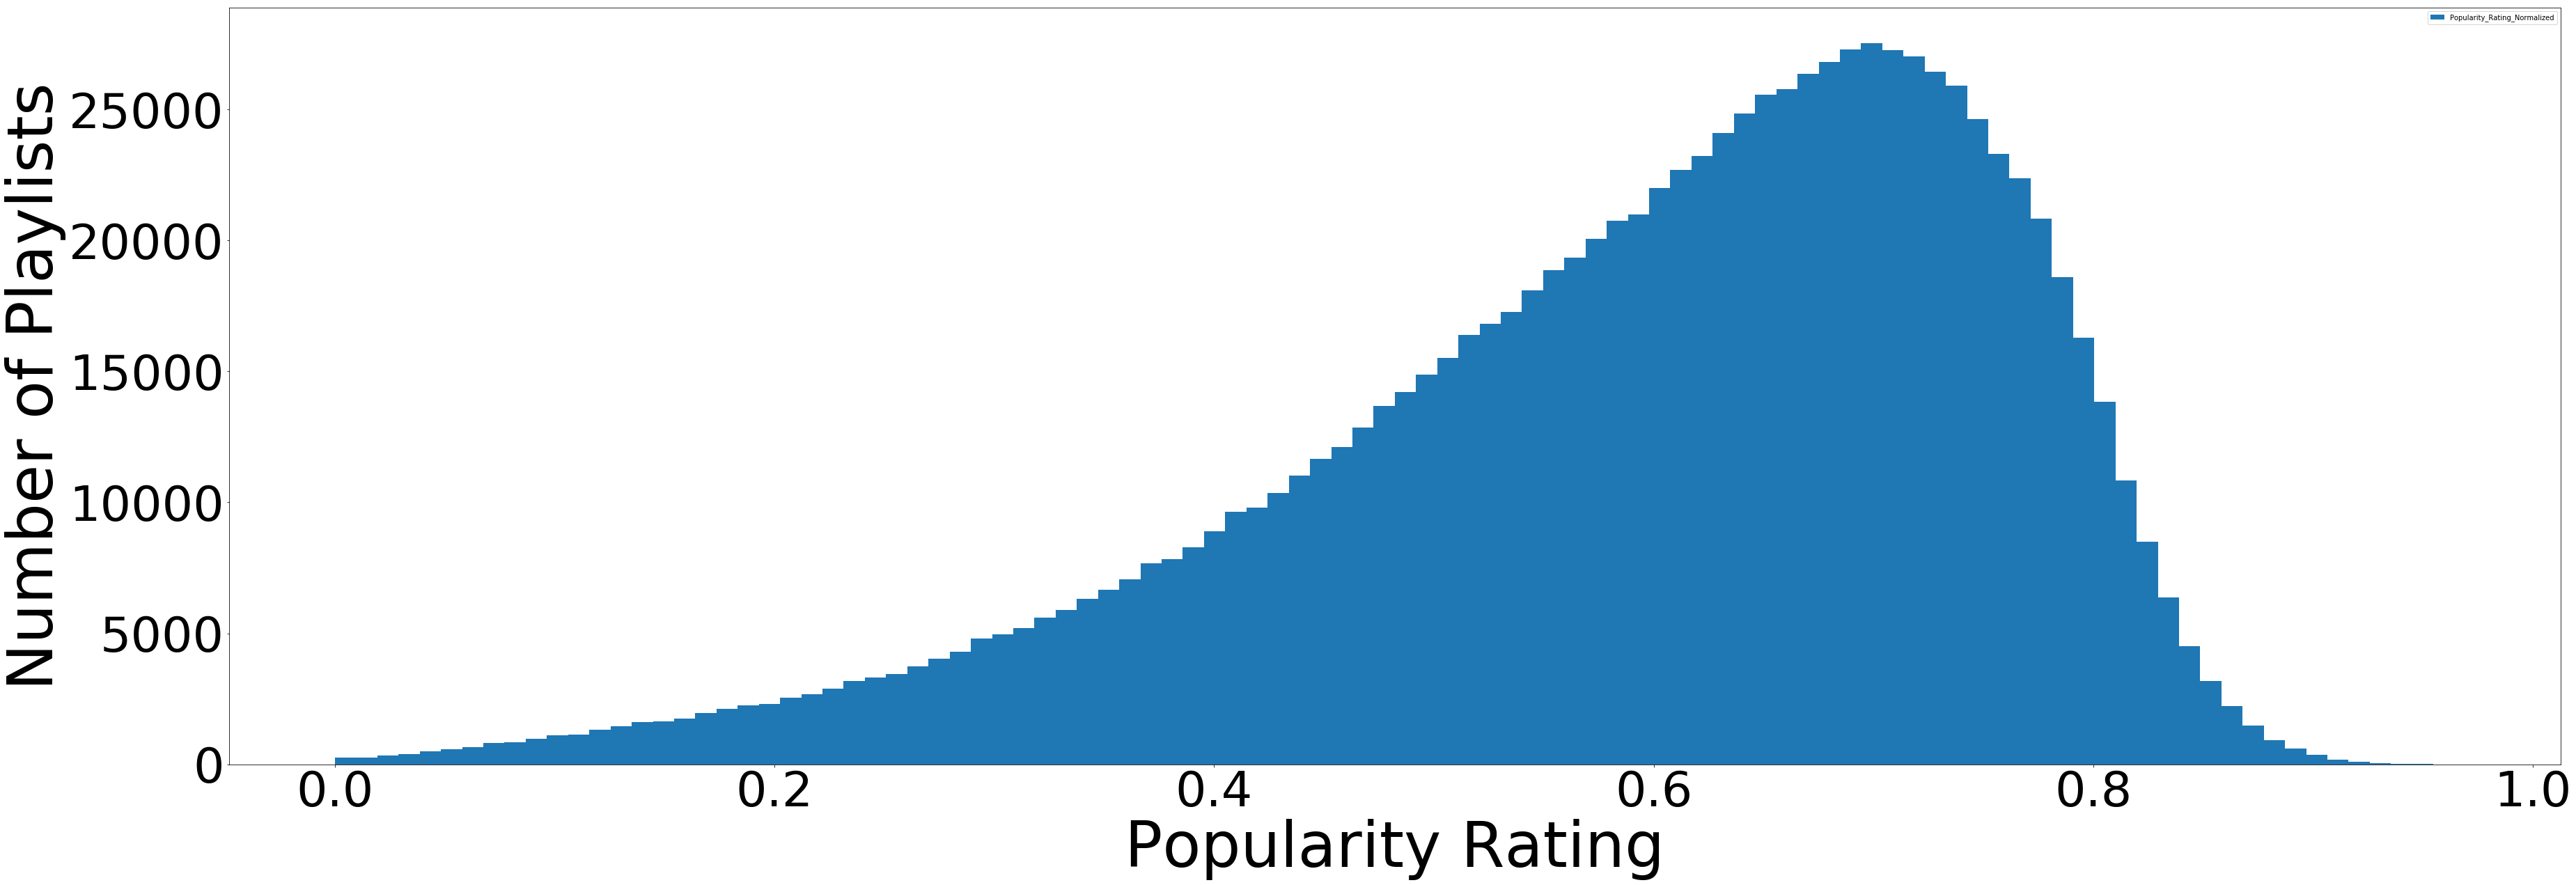

In [292]:
new = pd.DataFrame(grouped_playlists['Popularity_Rating_Normalized'])

fig = plt.figure()
new.plot(kind='hist',bins=100,figsize=(60,20),fontsize=70)
fig.suptitle('test title', fontsize=20)
plt.xlabel('Popularity Rating', fontsize=90)
plt.ylabel('Number of Playlists', fontsize=90)
plt.draw()

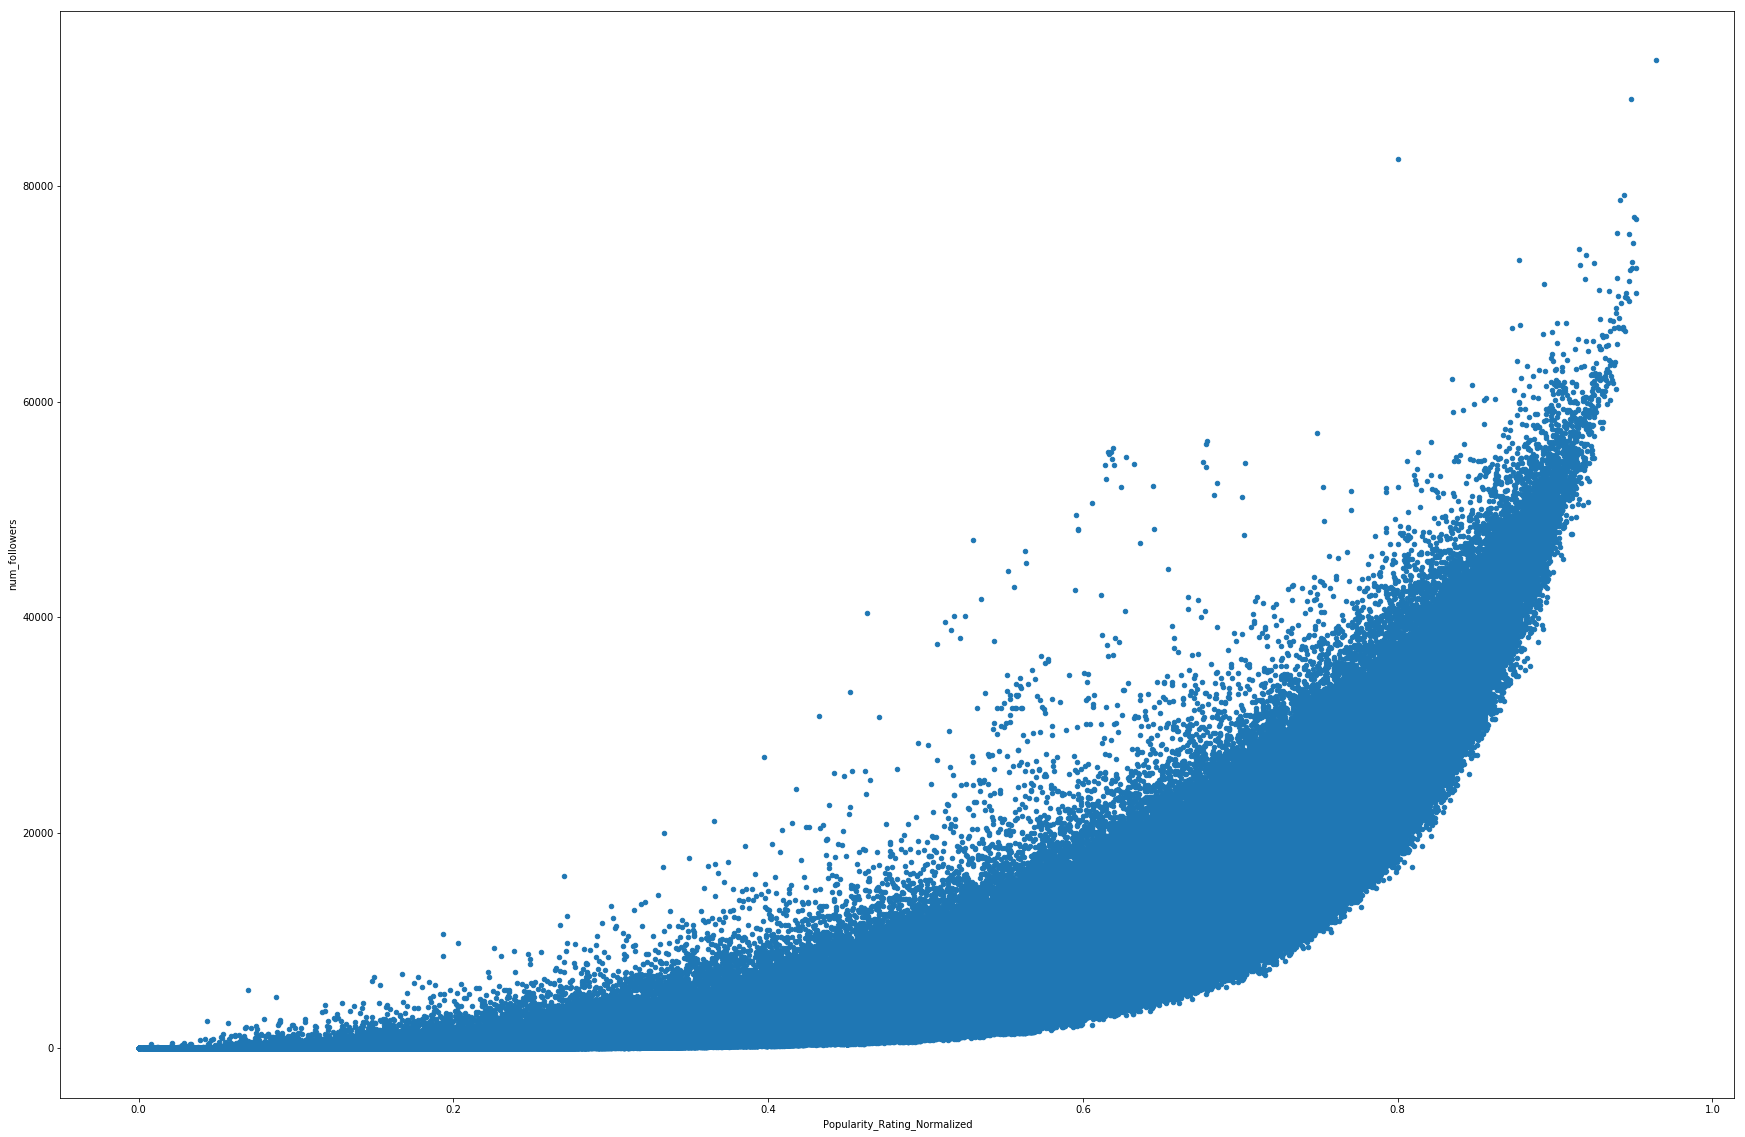

In [293]:
grouped_playlists.reset_index().plot(kind='scatter',x='Popularity_Rating_Normalized', y='num_followers',figsize=(30,20))